In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.constants import e
from tqdm.auto import tqdm
import pdb
%config InlineBackend.figure_formats = ['svg']

In [167]:
# here are the value from Pröbst paper used!

# Pulse shape model

In [123]:
# def det_2comp(t, T, C, Gb, Tb, G, P, t0):
#     matrix = np.array([
#         [(G[0,1] + Gb[0]) / C[0], -G[0,1] / C[0]],
#         [-G[0,1] / C[1], (G[0,1] + Gb[1]) / C[1]]
#     ])
#     P_ = P(t, t0)
#     rhs = np.array([P_[0] / C[0], P_[1] / C[1]])
#     d_delta_T_dt = rhs - matrix.dot(T)
#     return d_delta_T_dt

def det_therm(t, T, C, Gb, Tb, G, P, t0):
    
    dT = P(t, t0)  # heat input
    dT += Gb * (Tb - T)  # coupling to temperature bath
    dT += np.dot(G, T)  # heat transfer from other components
    dT -= np.dot(np.diag(np.dot(G, np.ones(T.shape[0]))),T)  # heat transfer to other components
    dT /= C  # heat to temperature

    return dT

In [270]:
C = np.array([1e-3,   
              .038])  # pJ/mK
Gb = np.array([3.,
               .7]) # heat cond to bath, pW/mK
Tb = np.array([0., 0.])  # temp bath
G_ea = 0.045  # pW/mK
G = np.array([[0., G_ea], 
              [G_ea, 0.], ])  # heat cond between components
lamb = 0.002  # thermalization time, s
eps = .08  # share in thermometer
eps_ = np.array([eps, 
                 (1-eps)])
delta = 0.  # share in thermometer
delta_ = np.array([delta, 
                 (1-delta)])

record_window = 8192
sample_frequency = 50000
t0 = record_window/sample_frequency/8  # onset time, s
er_keV = 60.  # keV!!!

e_charge = 1.60217663e-19  # coulombs
keV_to_pJ = e_charge * 1e3 * 1e12
er = er_keV*keV_to_pJ

def P_particle(x, t0):
    if t0 < x:
        retv = er*eps_*np.exp(-(x-t0)/lamb)/lamb 
    else:
        retv = np.zeros(eps_.shape)
    return retv  # pW

t = np.arange(0,record_window/sample_frequency,1/sample_frequency,)  # s

T0 = Tb * np.ones(C.shape[0])  # mK

time_step = t[1] - t[0]

In [271]:
%time Tp = odeint(det_therm, T0, t, args=(C, Gb, Tb, G, P_particle, t0), tfirst=True, tcrit=t)  # particle

CPU times: user 866 ms, sys: 14.7 ms, total: 880 ms
Wall time: 884 ms


In [272]:
# %time Tp_2comp = odeint(det_2comp, T0, t, args=(C, Gb, Tb, G, P_particle, t0), tfirst=True)#, tcrit=np.arange(t0 - 3 * time_step, t0 + lamb*10, time_step))  # particle

In [273]:
tau_n = lamb
G_eb = Gb[0]
G_ab = Gb[1]
C_e = C[0]
C_a = C[1]

a = (G_ea + G_eb) / C_e + (G_ea + G_ab) / C_a
b = (G_ea * G_eb + G_ea * G_ab + G_eb * G_ab) / (C_e * C_a)

tau_in = 2 / (a + np.sqrt(a**2 - 4 * b))
tau_t = 2 / (a - np.sqrt(a**2 - 4 * b))
s_in = 1 / tau_in
s_t = 1 / tau_t
s_n = 1 / tau_n

P_0 = eps * er / tau_n

A_n = (P_0 * (s_in - (G_ab / C_a))) 
A_n /= (eps * (s_in - s_t) * (s_in - s_n)) 
A_n *= ((s_t - (G_ab / C_a)) / (G_eb - (C_e / C_a) * G_ab) - (eps / C_e))

A_t = (P_0 * (s_t - (G_ab / C_a))) 
A_t /= (eps * (s_t - s_in) * (s_t - s_n))
A_t *= ((s_in - (G_ab / C_a)) / (G_eb - (C_e / C_a) * G_ab) - (eps / C_e))

alpha_in = 1 + G_ab / G_ea - s_in * C_a / G_ea
alpha_t = 1 + G_ab / G_ea - s_t * C_a / G_ea

A_n_me = (er / tau_n)  
A_n_me /= (1 - alpha_t / alpha_in)
A_n_me *= (alpha_t * (1 - eps) / C_a - eps / C_e)
A_n_me /= (1 / tau_n - 1 / tau_in)

A_t_me = (-er / tau_n) 
A_t_me /= (1 - alpha_in / alpha_t) 
A_t_me *= (alpha_in * (1 - eps) / C_a - eps / C_e) 
A_t_me *= (1 / tau_n - 1 / tau_t)**(-1)

A_n_abs_me = A_n_me / alpha_in
A_t_abs_me = A_t_me / alpha_t

coeff = A_n * (np.exp(-(t - t0) / tau_n) - np.exp(-(t - t0) / tau_in)) + A_t * (np.exp(-(t - t0) / tau_t) - np.exp(-(t - t0) / tau_n))
dTe_Franz = np.heaviside(t - t0, 1)*coeff

coeff_me = A_n_me * (np.exp(-(t - t0) / tau_n) - np.exp(-(t - t0) / tau_in)) + A_t_me * (np.exp(-(t - t0) / tau_t) - np.exp(-(t - t0) / tau_n))
dTe_me = np.heaviside(t - t0, 1)*coeff_me

coeff_abs_me = A_n_abs_me * (np.exp(-(t - t0) / tau_n) - np.exp(-(t - t0) / tau_in)) + A_t_abs_me * (np.exp(-(t - t0) / tau_t) - np.exp(-(t - t0) / tau_n))
dTa_me = np.heaviside(t - t0, 1)*coeff_abs_me

In [274]:
print(tau_n, tau_in, tau_t)

0.002 0.00032840532528201615 0.05105257857059286


In [275]:
print(alpha_in, alpha_t)

-2554.7926517832952 0.014874005518070277


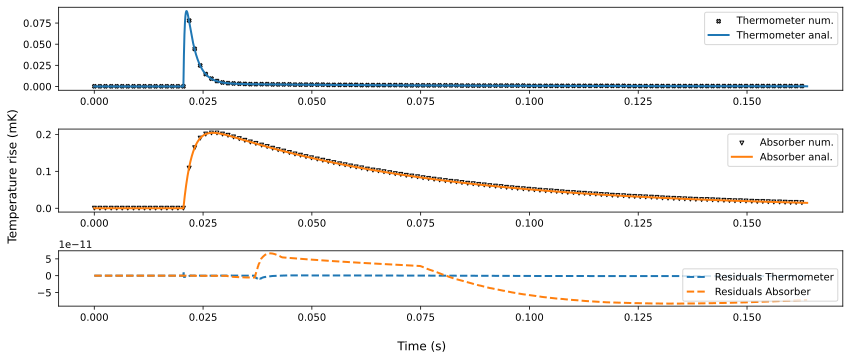

In [276]:
from matplotlib import gridspec

fig = plt.figure(figsize=(12,5), dpi=300) 
gs = gridspec.GridSpec(3, 1, height_ratios=[1.5, 1.5,1]) 
ax = [plt.subplot(gs[i]) for i in range(3)]

# fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True, dpi=300)

iv = int(record_window/128)

ax[0].scatter(t[::iv], Tp[::iv, 0], label='Thermometer num.', c='white', edgecolor='black', linewidth=1, rasterized=True, marker='X', s=15)
ax[0].plot(t, dTe_me, label='Thermometer anal.', c='C0', linewidth=2.)
# ax[0].plot(t, dTe_Franz, label='with orig. formula for $A_n$', c='black', linewidth=1, linestyle='dotted')
ax[0].legend(loc='upper right')

ax[1].scatter(t[::iv], Tp[::iv, 1], label='Absorber num.', c='white', linewidth=1, edgecolor='black', rasterized=True, marker='v', s=15)
ax[1].plot(t, dTa_me, label='Absorber anal.', c='C1', linewidth=2.)
ax[1].legend(loc='upper right')

ax[2].plot(t, Tp[:, 0] - dTe_me, label='Residuals Thermometer', c='C0', linewidth=2, linestyle='dashed')
ax[2].plot(t, Tp[:, 1] - dTa_me, label='Residuals Absorber', c='C1', linewidth=2, linestyle='dashed')
ax[2].legend(loc='lower right')

fig.supxlabel('Time (s)')
fig.supylabel('Temperature rise (mK)')
plt.tight_layout()
plt.savefig('plots_paper/confirm_formula.png')
plt.show()

In [277]:
import cryoenv.cryosig as cs

# Franz detector

In [1292]:
tc = 40.

det = cs.DetectorModel(C=np.array([C[0]/1.8225, 
                                   C[1]]),  # scaling to normal conducting TES 
                       Gb=Gb, 
                       Tb=lambda x: 15., 
                       G=G, 
                       lamb=np.array([lamb, lamb]), 
                       eps=np.array([eps_, eps_]), 
                       dac=np.array([10.]), 
                       Ib=np.array([5.]), 
                       record_length=8192*4, 
                       sample_frequency=50001, 
                       t0=0.04096,
                       Tc = np.array([tc]), 
                       k=np.array([.05*((40-20)/(tc-20.))]), 
                       Rt0=np.array([0.4]),
                       Rs=np.array([0.05]), 
                       emi=np.array([[5e-06, 0., 0.]]),
                       excess_johnson=np.array([1.]),
                       tes_fluct=np.array([0.00001]),
                       eta=np.array([57.8]),
                       lowpass=10000.,
                      )  

In [1293]:
det.solve_dac(R_op=0.1, limits=(0.,100.))

11.951891384078069

In [1294]:
det.wait(5)

In [1295]:
det.trigger(er=np.array([0., er_keV]), tpa=np.array([0.]))

T0 is [ 20.55891648 384.98053245] mK.
Calculated in 0.35501790046691895 s.
Generated noise in 0.012086153030395508 s.


In [1296]:
Tnum = det.get_temperatures()

In [1297]:
Tanal = det.get_thermal_pulseshape(er)

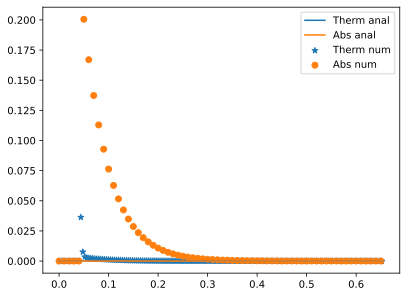

In [1298]:
plt.plot(det.t, Tanal[0], label='Therm anal')
plt.plot(det.t, Tanal[1], label='Abs anal')
plt.scatter(det.t[::200], Tnum[::200,0] - np.mean(Tnum[:2000,0]), label='Therm num', marker='*')
plt.scatter(det.t[::500], Tnum[::500,1] - np.mean(Tnum[:2000,1]), label='Abs num', marker='o')
plt.legend()

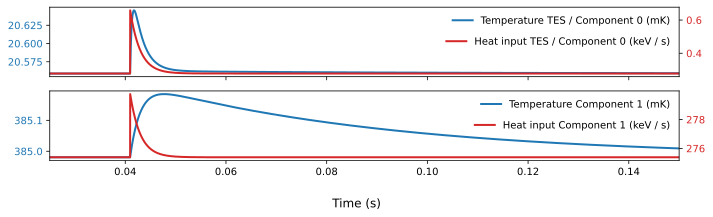

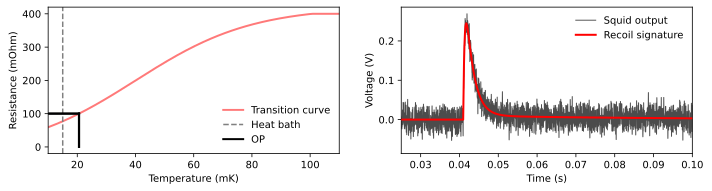

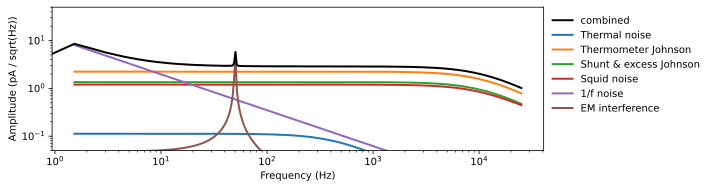

In [1299]:
det.plot_temperatures(xlim=(0.025,0.15))
fig, axes = det.plot_tes(xlim_time=(0.025,0.1), xlim_temp=(10,110), show=False)
for i in range(2):
    axes[i].set_title(None)
plt.savefig('plots_paper/tes_example.png')
plt.show()
det.plot_nps(show=False)
plt.title(None)
plt.ylim(0.05, 50)
plt.savefig('plots_paper/nps_example.png')
plt.show()

In [1300]:
therm_max = np.max(det.T[:,0]) - det.T[0,0]
abs_max = np.max(det.T[:,1]) - det.T[0,1]
print('therm_max, abs_max = ', therm_max, abs_max) 

therm_max, abs_max =  0.08647964711850165 0.20419856084981802


In [1301]:
_, tau_in_, tau_t_ = det.get_thermal_time_constants()
print('tau_in_, tau_t_ = ', tau_in_, tau_t_)
print('f_c_in_, f_c_t_ = ', 1/(2*tau_in_*np.pi), 1/(2*tau_t_*np.pi))

tau_in_, tau_t_ =  0.0003729524539958888 0.05105255733333477
f_c_in_, f_c_t_ =  426.7432520866313 3.1174724911963447


In [1302]:
An_, At_, An_a_, At_a_ = det.get_thermal_amplitudes(er=60.)
print('An_, At_, An_a_, At_a_ = ', An_, At_, An_a_, At_a_)

An_, At_, An_a_, At_a_ =  0.1542226247621788 0.0036058439441481556 -6.861477295338452e-05 0.24253808284286751


In [1303]:
print('Amplitude descrepancy thermometer: ', (An_ + At_)/therm_max)

Amplitude descrepancy thermometer:  1.8250359936142797


In [1304]:
print('Amplitude descrepancy absorber: ', (An_a_ + At_a_)/abs_max)

Amplitude descrepancy absorber:  1.1874200633972305


In [1305]:
pulse = det.Il.flatten() - det.Il[0]
Tt = det.T[0, 0]
It = det.It[0, 0]
w, nps = det.get_nps(Tt, It)

In [1306]:
pulse_fft = np.abs(np.fft.rfft(pulse)) ** 2
pulse_fft *= 2 / det.sample_frequency / det.sample_frequency  # need to argue this normalization!

In [1307]:
print('SNR of optimally filtered 1 keV pulse: {:.3}'.format(np.sqrt(np.trapz(pulse_fft[1:]/er_keV**2/nps[1:], w[1:]))))

SNR of optimally filtered 1 keV pulse: 0.991


In [1308]:
print('Energy resolution, optimally filtered: {:.3} keV'.format(1/(np.sqrt(np.trapz(pulse_fft[1:]/er_keV**2/nps[1:], w[1:])))))

Energy resolution, optimally filtered: 1.01 keV


# Check resolutions

In [1399]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [1578]:
def calc_resolution(er_keV=60., T_op=20.55, 
                    Geb=3., Gab=0.7, Gae=0.045, colleff=0.08, lamb=0.002, #values at 20.55 mK!
                    area_tes=2.5, vol_absorber=7700, surf_absorber=390, debye_temp=645000, tc=40., Ib=5.,  # area_tes would also include Al collectors
                    do_plot=False):
    
    # epsilon
    # eps = 1 / (1 + tau_film/tau_crystal)
    # tau_film = tau_0 / eta
    # eta linear in T, tau_crystal constant
    # tau_0 = 2 * V_a / area_tes / transition_prob
    tau_crystal = lamb / (1 - colleff) * (debye_temp/645000) * (390/surf_absorber) * (vol_absorber/7700)
    if colleff > 0:
        tau_film = lamb / colleff * (vol_absorber/7700) * (2.5/area_tes) * (debye_temp/645000)
        eps = 1 / (1 + tau_film/tau_crystal)
    else:
        eps = 0.
    
    # tau_n
    # tau_n = 1 / (1/tau_crystal + 1/tau_film)
    if colleff > 0:
        tau_n = 1 / (1/tau_crystal + 1/tau_film)
    else:
        tau_n = tau_crystal

    det = cs.DetectorModel(C=np.array([0.001 / 1.8225 * (T_op / 20.55) * (area_tes/2.5), 
                                       0.038 * (T_op / 20.55) ** 3 * (vol_absorber/7700)]),  # scaling to normal conducting TES 
                           Gb=np.array([Geb * (T_op / 20.55), 
                                        Gab * (T_op / 20.55) ** 3]), 
                           Tb=lambda x: 15., 
                           G=np.array([[0.   , Gae * (T_op / 20.55) ** 5 * (area_tes/2.5)],
                                       [Gae * (T_op / 20.55) ** 5 * (area_tes/2.5), 0.   ]]), 
                           lamb=tau_n*np.ones(2), 
                           eps=np.array([[eps, 1.0 - eps], 
                                         [eps, 1.0 - eps]]), 
                           dac=np.array([10.]), # 10
                           Ib=np.array([Ib]), # 5
                           record_length=32768, 
                           sample_frequency=50001, 
                           t0=0.04096, 
                           Tc = np.array([tc]), 
                           k=np.array([.05*((40-20)/(tc-20.))]), 
                           Rt0=np.array([0.4]), 
                           Rs=np.array([0.05]), 
                           emi=np.array([[5e-06, 0., 0.]]), 
                           excess_johnson=np.array([1.]), 
                           tes_fluct=np.array([0.00001]), 
                           eta=np.array([57.8]), 
                           lowpass=10000., 
                          )  
    
    det.solve_dac(R_op=det.Rt[0](T_op), limits=(0.,100.))
    
    det.wait(20)
    
    if do_plot:
        det.trigger(er=np.array([0., er_keV]), tpa=np.array([0.]))
    else:
        with HiddenPrints():
            det.trigger(er=np.array([0., er_keV]), tpa=np.array([0.]))
    
    if do_plot:
        det.plot_temperatures(xlim=(0.025,0.15))
        fig, axes = det.plot_tes(xlim_time=(0.025,0.1), xlim_temp=(10,110), show=False)
        for i in range(2):
            axes[i].set_title(None)
        plt.show()
        det.plot_nps(show=False)
        plt.title(None)
        plt.ylim(0.05, 50)
        plt.show()
        
    pulse = det.Il.flatten() - det.Il[0]
    Tt = det.T[0, 0]
    It = det.It[0, 0]
    w, nps = det.get_nps(Tt, It)
    
    pulse_fft = np.abs(np.fft.rfft(pulse)) ** 2
    pulse_fft *= 2 / det.sample_frequency / det.sample_frequency  # need to argue this normalization!
    
    tau_n, tau_in_, tau_t_ = det.get_thermal_time_constants()
    eres = 1/(np.sqrt(np.trapz(pulse_fft[1:]/er_keV**2/nps[1:], w[1:])))
    return eres, tau_n, tau_in_, tau_t_, eps
    

## investigate couplings isolated

In [1579]:
# athermal detector

all_vals = []
for g_ in [0.045, 1., 3.]:
    vals = []

    for g in tqdm(np.linspace(0.045, 3., 30)):
        eres, tau_n, tau_in, tau_t, eps_ = calc_resolution(T_op=20.55, Geb=g, Gab=0.7, Gae=g_, colleff=0.08, lamb=0.002)
        vals.append([eres, tau_n, tau_in, tau_t, eps_])
    
    all_vals.append(vals)
        
all_vals = np.array(all_vals)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [1580]:
# thermal detector

therm_all_vals = []
for g_ in [0.045, 1., 3.]:
    vals = []

    for g in tqdm(np.linspace(0.045, 3., 30)):
        eres, tau_n, tau_in, tau_t, eps_ = calc_resolution(T_op=20.55, Geb=g, Gab=0.7, Gae=g_, colleff=0.0, lamb=0.002)
        vals.append([eres, tau_n, tau_in, tau_t, eps_])
    
    therm_all_vals.append(vals)
        
therm_all_vals = np.array(therm_all_vals)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [1581]:
# athermal detector

sg_all_vals = []
for g_ in [0.045, 1., 3.]:
    vals = []

    for g in tqdm(np.linspace(0.045, 3., 30)):
        eres, tau_n, tau_in, tau_t, eps_ = calc_resolution(T_op=20.55, Geb=g, Gab=3., Gae=g_, colleff=0.08, lamb=0.002)
        vals.append([eres, tau_n, tau_in, tau_t, eps_])
    
    sg_all_vals.append(vals)
        
sg_all_vals = np.array(sg_all_vals)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [1582]:
# thermal detector

sg_therm_all_vals = []
for g_ in [0.045, 1., 3.]:
    vals = []

    for g in tqdm(np.linspace(0.045, 3., 30)):
        eres, tau_n, tau_in, tau_t, eps_ = calc_resolution(T_op=20.55, Geb=g, Gab=3., Gae=g_, colleff=0.0, lamb=0.002)
        vals.append([eres, tau_n, tau_in, tau_t, eps_])
    
    sg_therm_all_vals.append(vals)
        
sg_therm_all_vals = np.array(sg_therm_all_vals)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [1583]:
np.save('plots_paper/couplings_array.npy', all_vals)
np.save('plots_paper/couplings_array_therm.npy', therm_all_vals)
np.save('plots_paper/couplings_array_sg.npy', sg_all_vals)
np.save('plots_paper/couplings_array_sg_therm.npy', sg_therm_all_vals)

In [1584]:
all_vals = np.load('plots_paper/couplings_array.npy')
therm_all_vals = np.load('plots_paper/couplings_array_therm.npy')
sg_all_vals = np.load('plots_paper/couplings_array_sg.npy')
sg_therm_all_vals = np.load('plots_paper/couplings_array_sg_therm.npy')

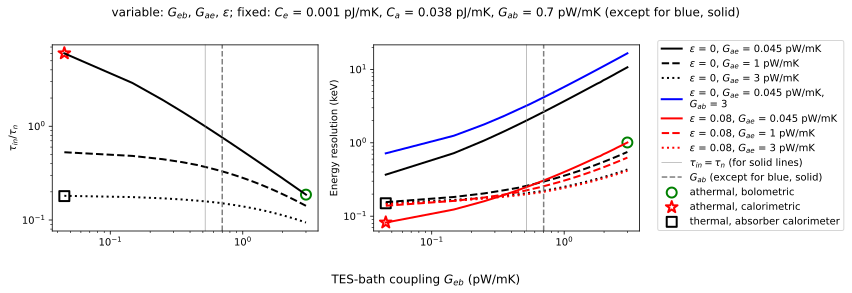

In [1585]:
fig, axes = plt.subplots(1,2, figsize=(12,4), sharex=True)

axes[0].plot(np.linspace(0.045, 3., 30), all_vals[0,:,2]/therm_all_vals[0,:,1], color='black', linewidth=2., linestyle='solid')
axes[0].plot(np.linspace(0.045, 3., 30), all_vals[1,:,2]/therm_all_vals[1,:,1], color='black', linewidth=2., linestyle='dashed')
axes[0].plot(np.linspace(0.045, 3., 30), all_vals[2,:,2]/therm_all_vals[2,:,1], color='black', linewidth=2., linestyle='dotted')
axes[0].axvline(0.52, color='grey', linestyle='solid', linewidth=.5)
axes[0].axvline(0.7, color='grey', linestyle='dashed', linewidth=1.5)
axes[0].set_ylabel(r'$\tau_{in} / \tau_{n}$')
axes[0].set_xscale('log')
axes[0].set_yscale('log')

axes[1].plot(np.linspace(0.045, 3., 30), therm_all_vals[0,:,0], color='black', linewidth=2., linestyle='solid', 
               label="$\epsilon$ = 0, $G_{ae}$ = 0.045 pW/mK")
axes[1].plot(np.linspace(0.045, 3., 30), therm_all_vals[1,:,0], color='black', linewidth=2., linestyle='dashed', 
               label="$\epsilon$ = 0, $G_{ae}$ = 1 pW/mK")
axes[1].plot(np.linspace(0.045, 3., 30), therm_all_vals[2,:,0], color='black', linewidth=2., linestyle='dotted', 
               label="$\epsilon$ = 0, $G_{ae}$ = 3 pW/mK")


axes[1].plot(np.linspace(0.045, 3., 30), sg_therm_all_vals[0,:,0], color='blue', linewidth=2., linestyle='solid', 
               label="$\epsilon$ = 0, $G_{ae}$ = 0.045 pW/mK, \n$G_{ab}$ = 3")


axes[1].plot(np.linspace(0.045, 3., 30), all_vals[0,:,0], color='red', linewidth=2., linestyle='solid', 
               label="$\epsilon$ = 0.08, $G_{ae}$ = 0.045 pW/mK")
axes[1].plot(np.linspace(0.045, 3., 30), all_vals[1,:,0], color='red', linewidth=2., linestyle='dashed', 
               label="$\epsilon$ = 0.08, $G_{ae}$ = 1 pW/mK")
axes[1].plot(np.linspace(0.045, 3., 30), all_vals[2,:,0], color='red', linewidth=2., linestyle='dotted', 
               label="$\epsilon$ = 0.08, $G_{ae}$ = 3 pW/mK")

# axes[1].plot(np.linspace(0.045, 3., 30), sg_all_vals[0,:,0], color='green', linewidth=2., linestyle='solid', 
#                label="$\epsilon$ = 0, $G_{ae}$ = 0.045 pW/mK, \n $G_{ab}$ = 3")

axes[1].axvline(0.52, color='grey', linestyle='solid', linewidth=.5, label=r'$\tau_{in} = \tau_{n}$ (for solid lines)')
axes[1].axvline(0.7, color='grey', linestyle='dashed', linewidth=1.5, label=r'$G_{ab}$ (except for blue, solid)')
axes[1].set_ylabel('Energy resolution (keV)')
axes[1].set_xscale('log')
axes[1].set_yscale('log')

axes[0].scatter([3.], [0.373/2], edgecolor='green', s=100, color='white', linewidth=2.)
axes[1].scatter([3.], [1.01], edgecolor='green', s=100, color='white', linewidth=2., label='athermal, bolometric')

axes[0].scatter([.045], [6.], edgecolor='red', s=150, color='white', marker='*', linewidth=2.)
axes[1].scatter([.045], [.082], edgecolor='red', s=150, color='white', marker='*', linewidth=2., label='athermal, calorimetric')

axes[0].scatter([.045], [.18], edgecolor='black', s=100, color='white', marker='s', linewidth=2.)
axes[1].scatter([.045], [.15], edgecolor='black', s=100, color='white', marker='s', linewidth=2., label='thermal, absorber calorimeter')

axes[1].legend(bbox_to_anchor=(1.05, 1.05))

fig.supxlabel(r'TES-bath coupling $G_{eb}$ (pW/mK)')
fig.suptitle(r"variable: $G_{eb}$, $G_{ae}$, $\epsilon$; fixed: $C_{e}$ = 0.001 pJ/mK, $C_{a}$ = 0.038 pJ/mK, $G_{ab}$ = 0.7 pW/mK (except for blue, solid)")
plt.tight_layout()
plt.show()

## investigate size TES - linear for Ce and Gae, complicated for epsilon and tau n

In [ ]:
# take bolo and calo and absorber calo modes

In [1586]:
bolo = {'Geb': 3., 'Gae': 0.045, 'colleff': 0.08}
calo = {'Geb': 0.045, 'Gae': 0.045, 'colleff': 0.08}
abs_calo = {'Geb': 0.045, 'Gae': 3., 'colleff': 0.}

In [1589]:
all_tes_sizes = []

for setup in [bolo, calo, abs_calo]:
    tes_sizes = []
    for a in tqdm(np.linspace(1.,50,30)):
        eres, tau_n, tau_in, tau_t, eps_ = calc_resolution(area_tes=a, **setup)
        tes_sizes.append([eres, tau_n, tau_in, tau_t, eps_])
    all_tes_sizes.append(tes_sizes)

all_tes_sizes = np.array(all_tes_sizes)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [1592]:
np.save('plots_paper/all_tes_sizes.npy', all_tes_sizes)

In [1593]:
all_tes_sizes = np.load('plots_paper/all_tes_sizes.npy')

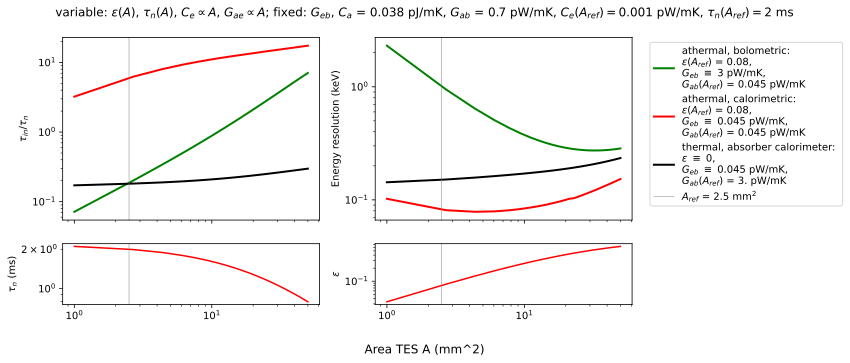

In [1654]:
fig, axes = plt.subplots(2,2, figsize=(12,5), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

axes[0,0].plot(np.linspace(1.,50,30), all_tes_sizes[0, :, 2]/all_tes_sizes[0, :, 1], color='green', linewidth=2.)
axes[0,0].plot(np.linspace(1.,50,30), all_tes_sizes[1, :, 2]/all_tes_sizes[0, :, 1], color='red', linewidth=2.)
axes[0,0].plot(np.linspace(1.,50,30), all_tes_sizes[2, :, 2]/all_tes_sizes[0, :, 1], color='black', linewidth=2.)
axes[0,0].set_ylabel(r'$\tau_{in} / \tau_{n}$')
axes[0,0].set_xscale('log')
axes[0,0].set_yscale('log')
axes[0,0].axvline(2.5, color='grey', linewidth=0.5)

axes[0,1].plot(np.linspace(1.,50,30), all_tes_sizes[0, :, 0], color='green', linewidth=2.,
            label="athermal, bolometric: \n$\epsilon(A_{ref})$ = 0.08, \n$G_{eb}$ $\equiv$ 3 pW/mK, \n$G_{ab}(A_{ref})$ = 0.045 pW/mK")
axes[0,1].plot(np.linspace(1.,50,30), all_tes_sizes[1, :, 0], color='red', linewidth=2.,
            label="athermal, calorimetric: \n$\epsilon(A_{ref})$ = 0.08, \n$G_{eb}$ $\equiv$ 0.045 pW/mK, \n$G_{ab}(A_{ref})$ = 0.045 pW/mK")
axes[0,1].plot(np.linspace(1.,50,30), all_tes_sizes[2, :, 0], color='black', linewidth=2.,
            label="thermal, absorber calorimeter: \n$\epsilon$ $\equiv$ 0, \n$G_{eb}$ $\equiv$ 0.045 pW/mK, \n$G_{ab}(A_{ref})$ = 3. pW/mK")
axes[0,1].set_ylabel('Energy resolution (keV)')
axes[0,1].set_xscale('log')
axes[0,1].set_yscale('log')
axes[0,1].axvline(2.5, color='grey', linewidth=0.5, label='$A_{ref}$ = 2.5 mm$^2$')
axes[0,1].legend(bbox_to_anchor=(1.05, 1.0))

axes[1,0].plot(np.linspace(1.,50,30), 1000*all_tes_sizes[0,:,1], color='red')
axes[1,0].axvline(2.5, color='grey', linewidth=0.5)
axes[1,0].set_ylabel(r'$\tau_n$ (ms)')
axes[1,0].set_yscale('log')
axes[1,1].plot(np.linspace(1.,50,30), all_tes_sizes[0,:,-1], color='red')
axes[1,1].axvline(2.5, color='grey', linewidth=0.5)
axes[1,1].set_ylabel(r'$\epsilon$')
axes[1,1].set_yscale('log')

fig.supxlabel('Area TES A (mm^2)')
fig.suptitle(r"variable: $\epsilon(A)$, $\tau_n(A)$, $C_{e} \propto A$, $G_{ae} \propto A$; fixed: $G_{eb}$, $C_{a}$ = 0.038 pJ/mK, $G_{ab}$ = 0.7 pW/mK, $C_e(A_{ref})=0.001$ pW/mK, $\tau_n(A_{ref})=2$ ms")
plt.tight_layout()
plt.show()

## investigate volume absorber 

In [ ]:
# take bolo and calo and absorber calo modes

In [ ]:
# same plot as above

## investigate Debye temperature

In [ ]:
# take bolo and calo and absorber calo modes

In [ ]:
# same plot as above

## investigate operation temperature

In [ ]:
# same plot as above

## steepness of transition curve, constant temperature - here also consider bias current

In [ ]:
# x axis is k

# for different bias currents!